# First Look at Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

## Consumption Data

In [2]:
con_data = pd.read_excel("/Users/darcor/Library/Mobile Documents/com~apple~CloudDocs/Uni/Master/EDP - Thesis/Data/Consumption Data/Portugal_Consumption_2023_2025_15min.xlsx")
con_data.rename(columns={'Total (kWh)': 'Total Con (kWh)'}, inplace=True)

## Production Data

In [3]:
prod_data_alt = pd.read_excel("/Users/darcor/Library/Mobile Documents/com~apple~CloudDocs/Uni/Master/EDP - Thesis/Data/Consumption Data/Portugal_Produced_Energy_2023_2025_15min.xlsx")
prod_data = pd.read_excel("/Users/darcor/Library/Mobile Documents/com~apple~CloudDocs/Uni/Master/EDP - Thesis/Data/Consumption Data/Portugal_Produced_Energy_Renewables_2023_2025_15min.xlsx")
prod_data_alt.rename(columns={'Total (kWh)': 'Total Prod (kWh)'}, inplace=True)

## Market Shares of EDP

In [4]:
ms_edp = pd.read_csv("/Users/darcor/Library/Mobile Documents/com~apple~CloudDocs/Uni/Master/EDP - Thesis/Data/Keydata/Market Shares EDP/ML_Consumption_Data.csv")

## Energy Prices 2023-2025

In [4]:
df = pd.read_excel("/Users/darcor/Data/EDP Thesis/Output/e-redes-data/redes_data.xlsx")
plants = pd.read_excel("/Users/darcor/PycharmProjects/Setup/Data/Plants_EDP.xlsx", sheet_name="ALL")

## Geographics of all Plants

In [10]:
import folium
from folium.plugins import MarkerCluster
import pandas as pd

# Create a base map centered on Portugal
m = folium.Map(location=[39.5, -8.0], zoom_start=6)

# Create a MarkerCluster
marker_cluster = MarkerCluster().add_to(m)

# Define a mapping for plant type to Font Awesome icons
icon_mapping = {
    'wind':  {'icon': 'wind', 'color': 'green'},
    'solar': {'icon': 'sun',  'color': 'orange'},
    'hydro': {'icon': 'tint', 'color': 'blue'}
}

# Add markers with clustering
for idx, row in plants.iterrows():
    plant_type = row['Type']
    icon_info = icon_mapping.get(plant_type, {'icon': 'info-sign', 'color': 'gray'})
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"<strong>{row['Plant Name']}</strong><br>Type: {plant_type}<br>Capacity: {row['Total Capacity (MW)']} MW",
        icon=folium.Icon(icon=icon_info['icon'], prefix='fa', color=icon_info['color'])
    ).add_to(marker_cluster)

# Save or display the map
m.save("portugal_plants_map_clustered.html")
m

In [11]:
# Create a base map centered on Portugal
m = folium.Map(location=[39.5, -8.0], zoom_start=6)

# Add markers to the map
for idx, row in plants.iterrows():
    plant_type = row['Type']
    icon_info = icon_mapping.get(plant_type, {'icon': 'info-sign', 'color': 'gray'})
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(
            f"<strong>{row['Plant Name']}</strong><br>"
            f"Type: {plant_type}<br>"
            f"Capacity: {row['Total Capacity (MW)']} MW", max_width=200),
        icon=folium.Icon(icon=icon_info['icon'], prefix='fa', color=icon_info['color'])
    ).add_to(m)

# Save or display the map
m.save("portugal_plants_map.html")
m

In [15]:
from folium.features import DivIcon

# Create a base map centered on Portugal
m = folium.Map(location=[39.5, -8.0], zoom_start=6)

# Define a base icon size and scaling factor
base_size = 20        # minimum font size in pixels
scaling_factor = 0.05 # adjust this to control how much the capacity affects the size

# Add markers with dynamic icon sizes using DivIcon
for idx, row in plants.iterrows():
    plant_type = row['Type']
    capacity = row['Total Capacity (MW)']
    icon_info = icon_mapping.get(plant_type, {'icon': 'info-sign', 'color': 'gray'})
    
    # Calculate the icon's font size based on capacity
    icon_size = base_size + capacity * scaling_factor
    
    # Create HTML for the DivIcon with dynamic font size
    icon_html = f"""
    <div style="font-size: {icon_size}px; color: {icon_info['color']};">
        <i class="fa fa-{icon_info['icon']}"></i>
    </div>
    """
    
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(
            f"<strong>{row['Plant Name']}</strong><br>"
            f"Type: {plant_type}<br>"
            f"Capacity: {capacity} MW",
            max_width=200
        ),
        icon=DivIcon(html=icon_html)
    ).add_to(m)

# Save or display the map
m.save("portugal_plants_map_dynamic_icon_size.html")
m

## Consumption Trends over time (2023-2025)

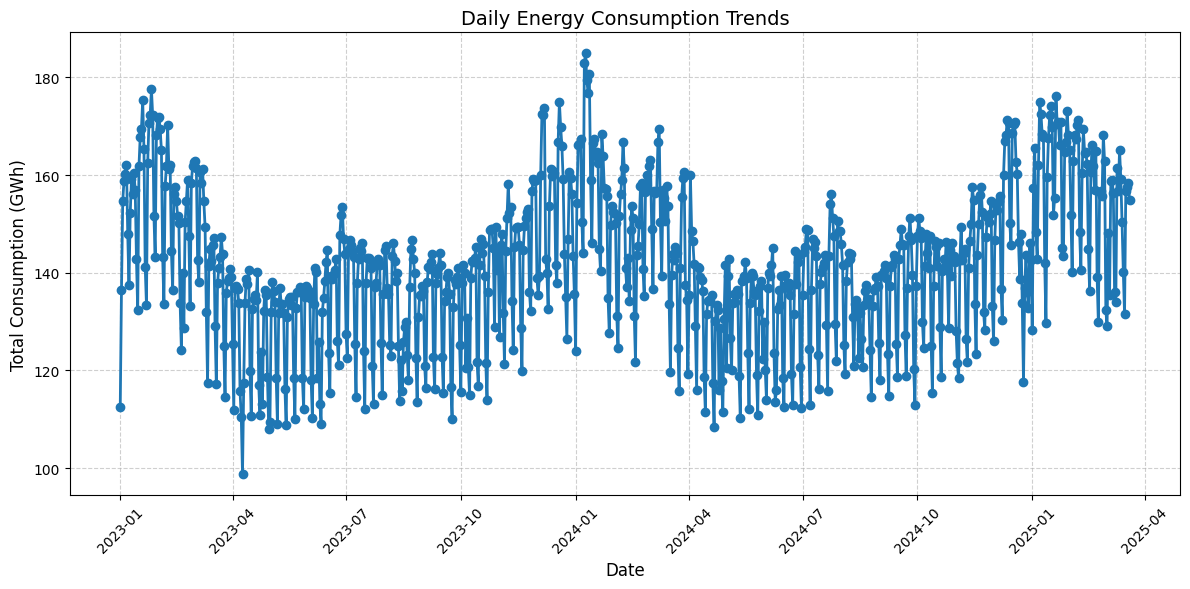

In [6]:
# Group by Date and sum the total consumption
df_daily = df.groupby(df['Date/Time'].dt.date)['Total Con (GWh)'].sum().reset_index()
df_daily['Date/Time'] = pd.to_datetime(df_daily['Date/Time'])

df_daily = df_daily[df_daily['Date/Time'] <= '2025-03-20']

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_daily['Date/Time'], df_daily['Total Con (GWh)'], marker='o', linestyle='-', linewidth=2)

# Formatting
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Consumption (GWh)', fontsize=12)
plt.title('Daily Energy Consumption Trends', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()

You can clearly see a pattern of intramonth peaks and bottoms probably aligning with vacation days etc

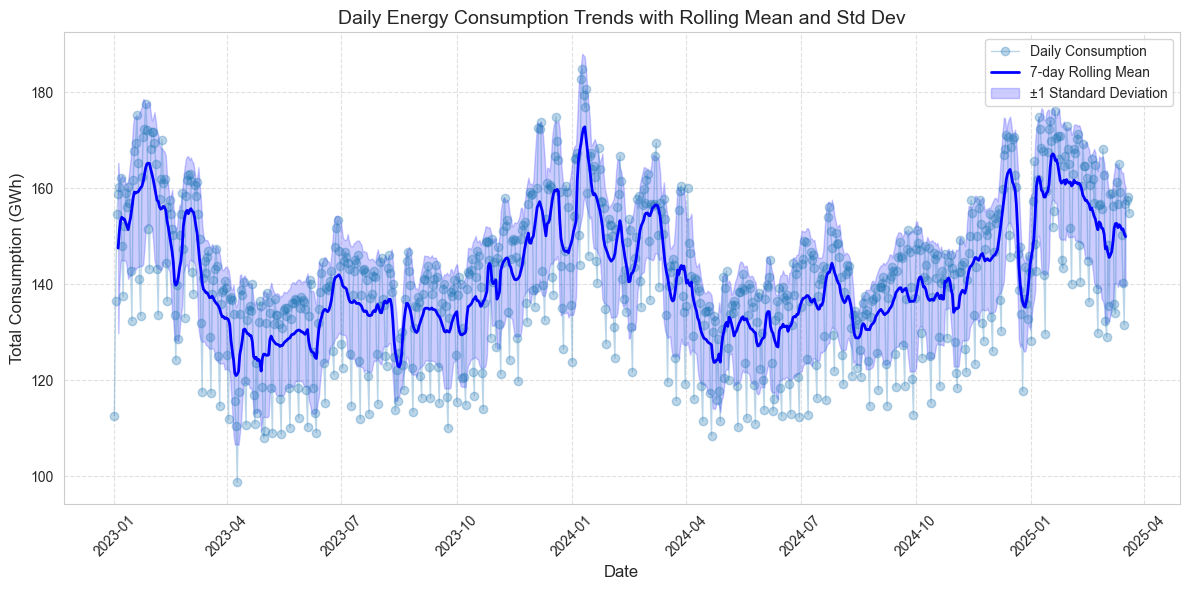

In [7]:
sns.set_style('whitegrid')

window_size = 7

# Compute rolling mean and std
df_daily['rolling_mean'] = (
    df_daily['Total Con (GWh)']
    .rolling(window=window_size, center=True)
    .mean()
)
df_daily['rolling_std'] = (
    df_daily['Total Con (GWh)']
    .rolling(window=window_size, center=True)
    .std()
)

plt.figure(figsize=(12, 6))

# Plot the original daily data (faint to emphasize the rolling trend)
plt.plot(
    df_daily['Date/Time'], 
    df_daily['Total Con (GWh)'], 
    marker='o', linestyle='-', 
    linewidth=1, alpha=0.3, 
    label='Daily Consumption'
)

# Plot the rolling mean
plt.plot(
    df_daily['Date/Time'], 
    df_daily['rolling_mean'], 
    color='blue', 
    linewidth=2, 
    label=f'{window_size}-day Rolling Mean'
)

# Fill between (mean - std) and (mean + std) to create a "confidence band"
plt.fill_between(
    df_daily['Date/Time'],
    df_daily['rolling_mean'] - df_daily['rolling_std'],
    df_daily['rolling_mean'] + df_daily['rolling_std'],
    color='blue', alpha=0.2,
    label='±1 Standard Deviation'
)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Consumption (GWh)', fontsize=12)
plt.title('Daily Energy Consumption Trends with Rolling Mean and Std Dev', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

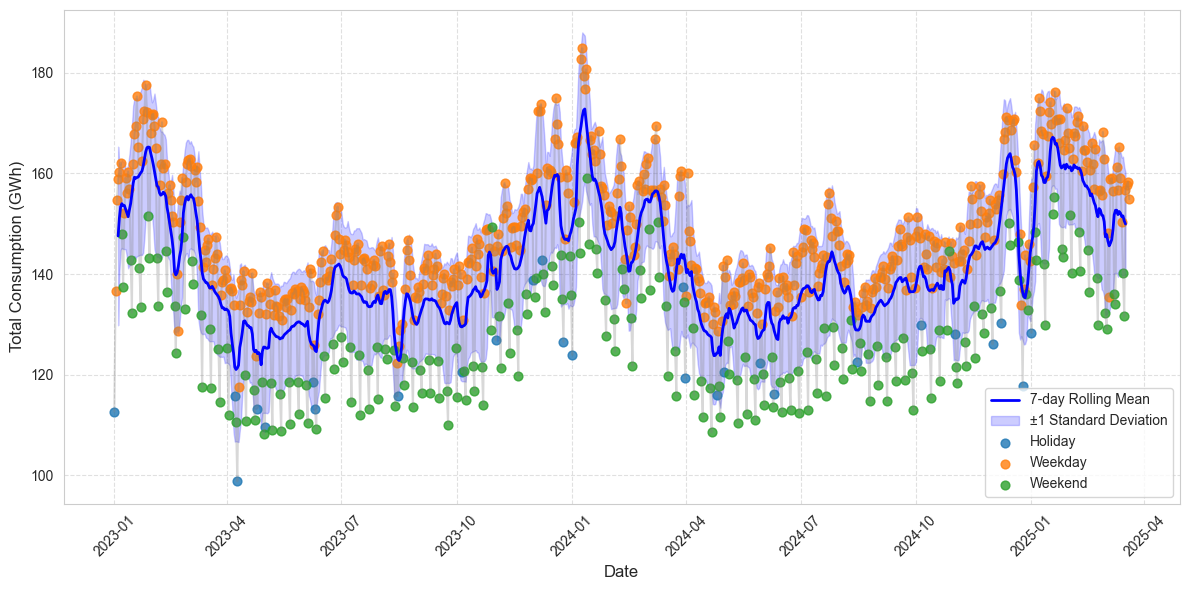

In [10]:
window_size = 7

df_daily = (
    df.groupby(df['Date/Time'].dt.date)
      .agg({
          'Total Con (GWh)': 'sum',
          'Holiday': 'max' 
      })
      .reset_index()
      .rename(columns={'Date/Time': 'Date'})  # rename the grouped column to 'Date'
)

# Convert that 'Date' back to datetime
df_daily['Date'] = pd.to_datetime(df_daily['Date'])

df_daily = df_daily[df_daily['Date'] <= '2025-03-20']

# Create a column to categorize each day:
#   - "Holiday" if Holiday == 1
#   - "Weekend" if Saturday (5) or Sunday (6)
#   - "Weekday" otherwise
df_daily['day_type'] = np.where(
    df_daily['Holiday'] == 1,
    'Holiday',
    np.where(df_daily['Date'].dt.weekday >= 5, 'Weekend', 'Weekday')
)

# Compute rolling mean and std
df_daily['rolling_mean'] = (
    df_daily['Total Con (GWh)']
    .rolling(window=window_size, center=True)
    .mean()
)
df_daily['rolling_std'] = (
    df_daily['Total Con (GWh)']
    .rolling(window=window_size, center=True)
    .std()
)

# Plot
plt.figure(figsize=(12, 6))

plt.plot(
    df_daily['Date'], 
    df_daily['Total Con (GWh)'], 
    color='gray', 
    alpha=0.3, 
    label='_nolegend_'  # Hide from legend
)

plt.plot(
    df_daily['Date'], 
    df_daily['rolling_mean'], 
    color='blue', 
    linewidth=2, 
    label=f'{window_size}-day Rolling Mean'
)

plt.fill_between(
    df_daily['Date'],
    df_daily['rolling_mean'] - df_daily['rolling_std'],
    df_daily['rolling_mean'] + df_daily['rolling_std'],
    color='blue', alpha=0.2,
    label='±1 Standard Deviation'
)

# Now scatter-plot each category in a different color
for category, group_data in df_daily.groupby('day_type'):
    plt.scatter(
        group_data['Date'],
        group_data['Total Con (GWh)'],
        s=40,
        alpha=0.8,
        label=category
    )

plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Consumption (GWh)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

On weekends and on national holidays the consumption is definitly lower

/var/folders/dg/bb0t3rbx0wl1m8sfz_m5h2bw0000gn/T/ipykernel_71104/3322151764.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_monthly = df_monthly.groupby(df['Date/Time'].dt.to_period('M'))['Total Con (GWh)'].sum().reset_index()


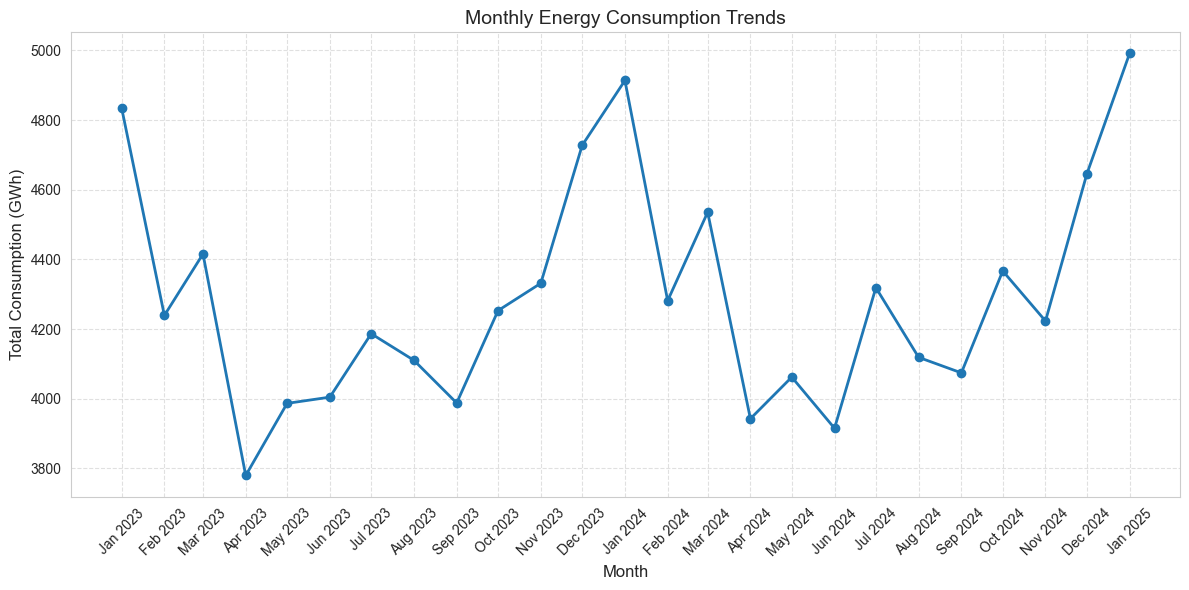

In [99]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'], utc=True)

df_monthly = df[df['Date/Time']< '2025-02-01 00:00:00+00:00']
df_monthly = df_monthly.groupby(df['Date/Time'].dt.to_period('M'))['Total Con (GWh)'].sum().reset_index()

# Convert Period to datetime for Matplotlib
df_monthly['Date/Time'] = df_monthly['Date/Time'].astype(str)  # Convert period to string
df_monthly['Date/Time'] = pd.to_datetime(df_monthly['Date/Time'])  # Convert to datetime

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_monthly['Date/Time'], df_monthly['Total Con (GWh)'], marker='o', linestyle='-', linewidth=2)

# Formatting
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Consumption (GWh)', fontsize=12)
plt.title('Monthly Energy Consumption Trends', fontsize=14)
plt.xticks(df_monthly['Date/Time'], df_monthly['Date/Time'].dt.strftime('%b %Y'), rotation=45)  # Format X-axis
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()

Consumption is the lowest in spring and peaks in the winter

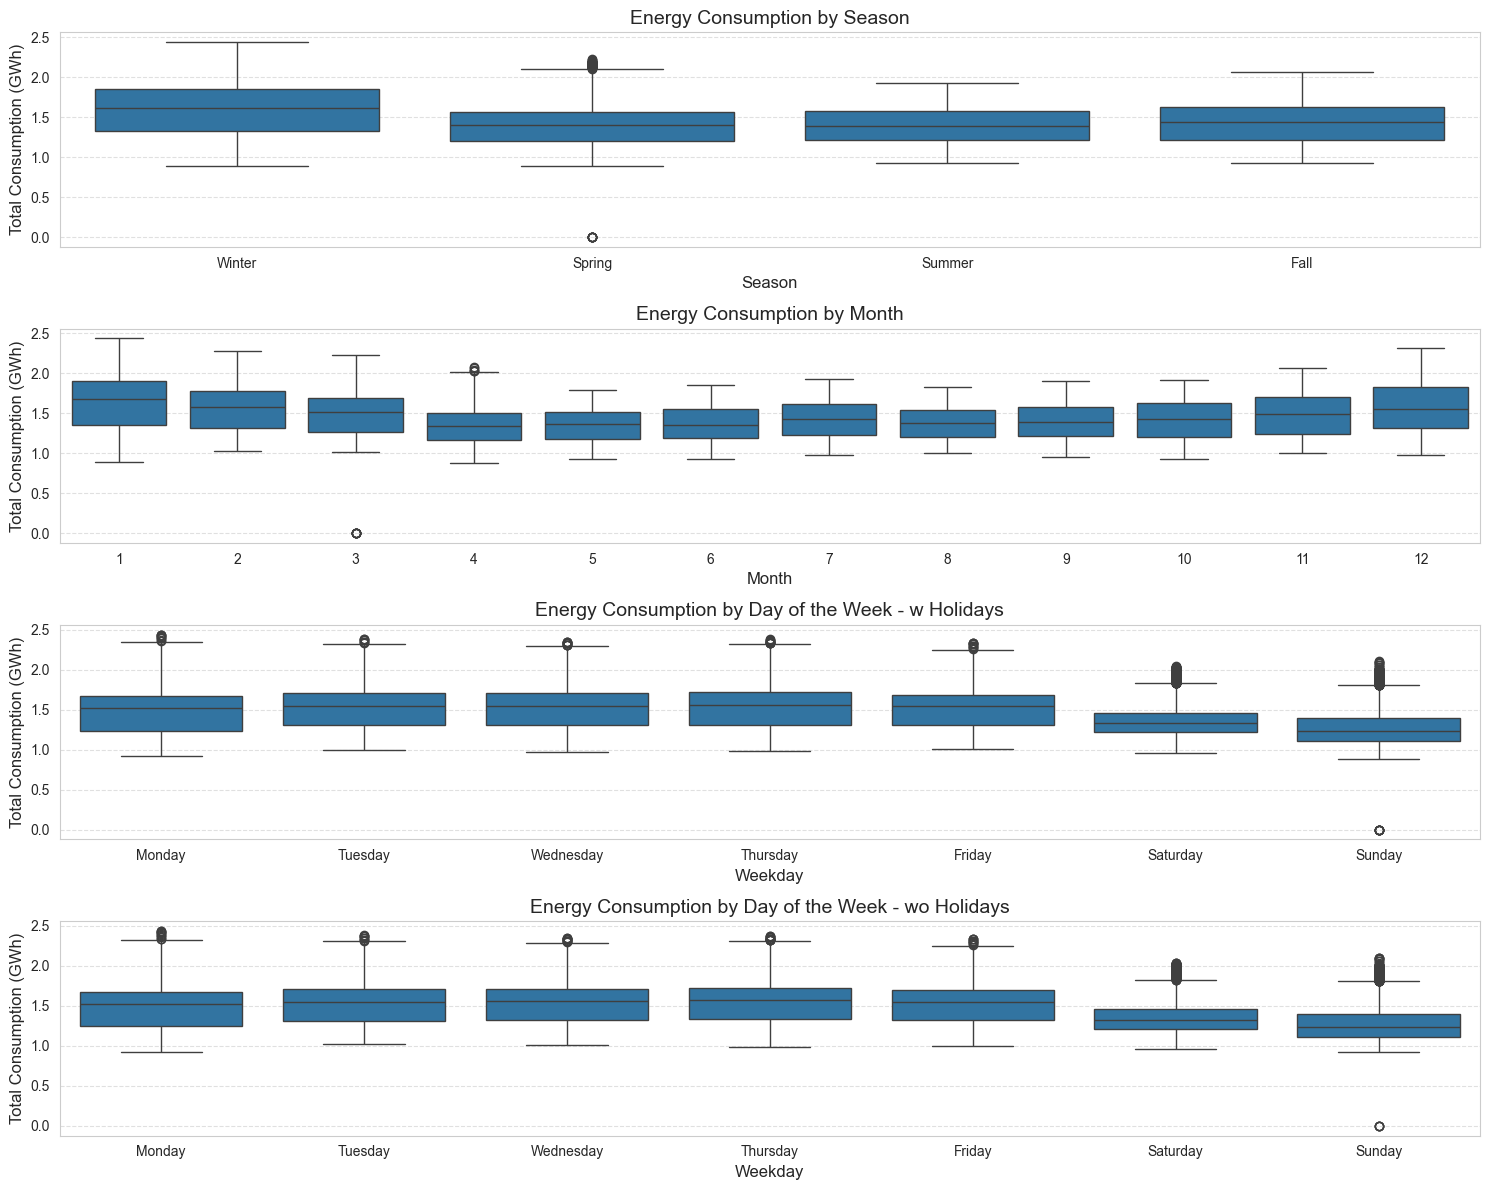

In [100]:
# Set figure size
plt.figure(figsize=(15, 12))

# Boxplot for Seasons
plt.subplot(4, 1, 1)
sns.boxplot(x='Season', y='Total Con (GWh)', data=df, order=['Winter', 'Spring', 'Summer', 'Fall'])
plt.title('Energy Consumption by Season', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Total Consumption (GWh)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Boxplot for Months
plt.subplot(4, 1, 2)
sns.boxplot(x='Month', y='Total Con (GWh)', data=df)
plt.title('Energy Consumption by Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Consumption (GWh)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Boxplot for Weekdays
plt.subplot(4, 1, 3)
sns.boxplot(x='Weekday', y='Total Con (GWh)', data=df, order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
plt.title('Energy Consumption by Day of the Week - w Holidays', fontsize=14)
plt.xlabel('Weekday', fontsize=12)
plt.ylabel('Total Consumption (GWh)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.subplot(4, 1, 4)
sns.boxplot(x='Weekday', y='Total Con (GWh)', data=df[df['Holiday']==0], order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
plt.title('Energy Consumption by Day of the Week - wo Holidays', fontsize=14)
plt.xlabel('Weekday', fontsize=12)
plt.ylabel('Total Consumption (GWh)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

## Production Over Time - Share of Energy Sources

<Figure size 1200x600 with 0 Axes>

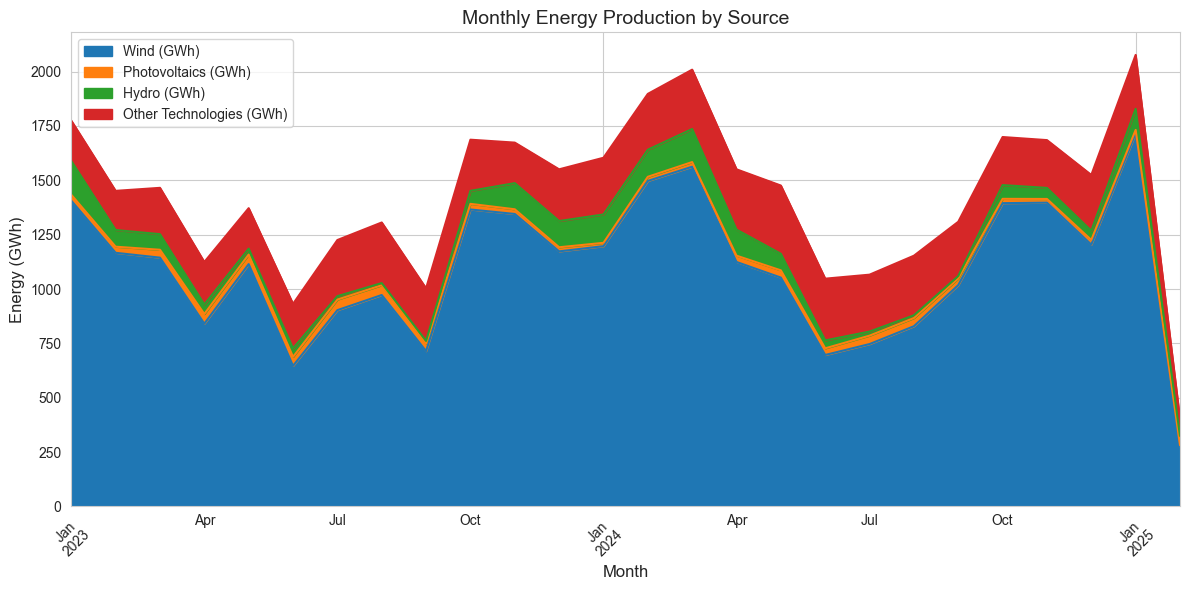

In [ ]:
sns.set_style('whitegrid')

df_daily = (
    df.groupby(df['Date/Time'].dt.date)
      .agg({
          'Wind (GWh)': 'sum',
          'Photovoltaics (GWh)': 'sum',
          'Hydro (GWh)': 'sum',
          'Other Technologies (GWh)': 'sum',
          'Holiday': 'max' 
      })
      .reset_index()
      .rename(columns={'Date/Time': 'Date'})
)
df_daily['Date'] = pd.to_datetime(df_daily['Date'])

df_monthly = df_daily.set_index('Date').resample('MS').sum().reset_index()

plt.figure(figsize=(12, 6))

df_monthly.plot(
    x='Date',
    y=['Wind (GWh)', 'Photovoltaics (GWh)', 'Hydro (GWh)', 'Other Technologies (GWh)'],
    kind='area',
    stacked=True,
    figsize=(12, 6),
    # optional custom colors:
    color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
)

plt.title('Monthly Energy Production by Source', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Energy (GWh)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()



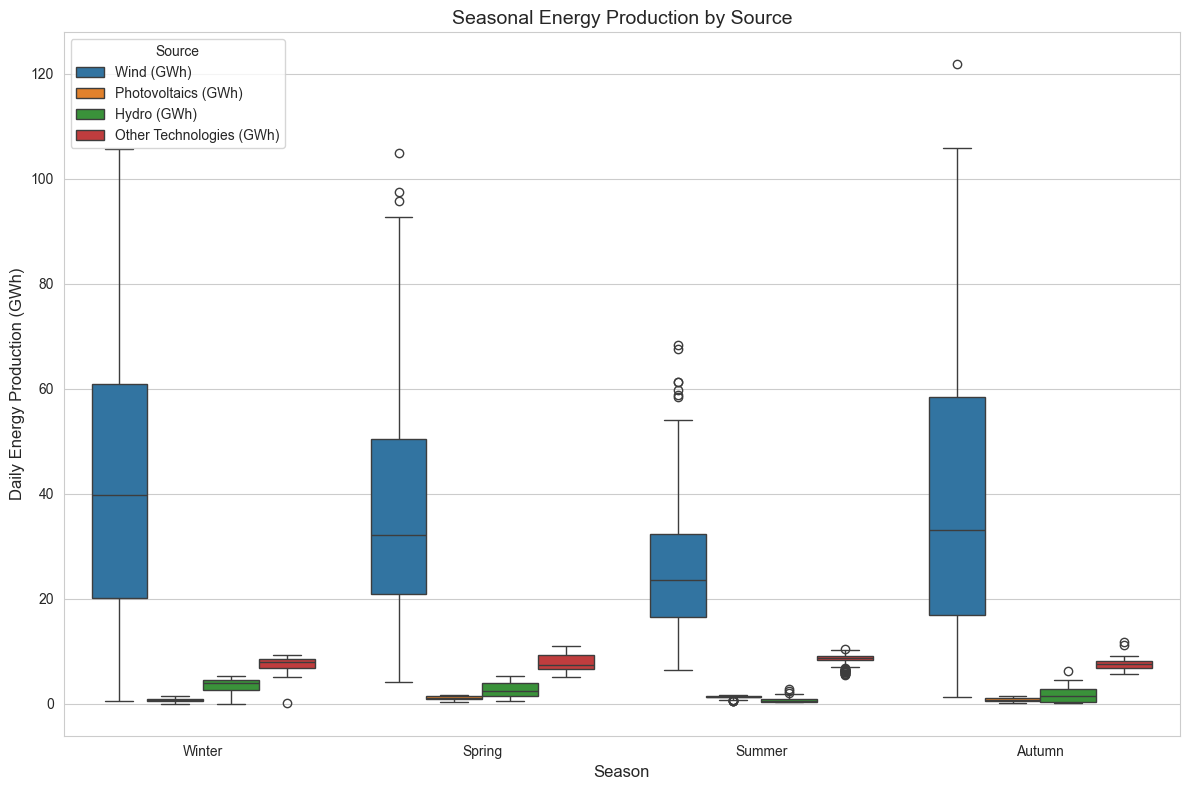

In [105]:
import seaborn as sns

# Define a helper function to assign season based on month
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df_daily['Season'] = df_daily['Date'].dt.month.apply(assign_season)

# Melt the DataFrame to have a 'Source' column and corresponding 'Energy' values
df_melt = df_daily.melt(
    id_vars=['Date', 'Season'], 
    value_vars=['Wind (GWh)', 'Photovoltaics (GWh)', 'Hydro (GWh)', 'Other Technologies (GWh)'],
    var_name='Source', 
    value_name='Energy (GWh)'
)

plt.figure(figsize=(12, 8))
sns.boxplot(x='Season', y='Energy (GWh)', hue='Source', data=df_melt)
plt.title('Seasonal Energy Production by Source', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Daily Energy Production (GWh)', fontsize=12)
plt.legend(title='Source')
plt.tight_layout()
plt.show()

## Residual Load - Seasonality

In [14]:
df.groupby('Year')['Total Con (GWh)'].sum()

Year
2023    50819.370563
2024    51394.303968
2025    12686.032870
Name: Total Con (GWh), dtype: float64

In [27]:
daily_avg = df.groupby('Date')['Total Con (GWh)'].mean()
overall_avg = daily_avg.mean()
print(overall_avg)

1.4730366349586625


In [26]:
daily_totals = (df.groupby('Date')['Market (kWh)'].sum()) / 1000000

# Step 3: Compute the average of the daily totals
average_daily_residual_load = daily_totals.mean()
print(average_daily_residual_load)

90.68030032718328


In [23]:
df['Portugal Price (€/MW)'].mean()

78.3557780512505

## Residual Load - Time of the day

In [1]:
import pandas as pd
df = pd.read_parquet('/Users/darcor/Data/EDP Thesis/Output/Photovoltaic_era5.parquet', engine="fastparquet")

## Solar Train Data

In [3]:
import pandas as pd
df = pd.read_parquet('/Users/darcor/Data/EDP Thesis/Output/Solar Data/solar_data.parquet', engine="fastparquet")
if not pd.api.types.is_datetime64_any_dtype(df["LocalTime"]):
    df["LocalTime"] = pd.to_datetime(df["LocalTime"], errors='coerce')
mask = (
        df["LocalTime"].dt.minute.eq(0)
        & df["LocalTime"].dt.second.eq(0)
        & df["LocalTime"].dt.microsecond.eq(0)
)
df = df[mask]

In [2]:
df.describe()

,LocalTime,Power(MW),latitude,longitude,year,capacity_MW,grid_latitude,grid_longitude,distance,dist_in_km,...,tp,snd,clear_sky_index,hour,hour_sin,hour_cos,day_of_year,doy_sin,doy_cos,net_radiation
count,12588543,1.258854e+07,1.258854e+07,1.258854e+07,12588543.0,1.258854e+07,1.258854e+07,1.258854e+07,1.258854e+07,1.258854e+07,...,1.258854e+07,12588543.0,1.258854e+07,1.258854e+07,1.258854e+07,1.258854e+07,1.258854e+07,1.258854e+07,1.258854e+07,1.258854e+07
mean,2006-07-06 18:41:13.874601216,2.287420e+01,3.514914e+01,-9.103278e+01,2006.0,7.708413e+01,3.517051e+01,-9.105541e+01,9.760758e-02,9.865361e+00,...,1.057444e-04,0.0,2.012015e+06,1.300858e+01,-1.233654e-01,-4.546464e-01,1.872366e+02,-3.208619e-02,-6.036217e-02,-2.144623e+04
min,2006-01-01 06:00:00,0.000000e+00,2.515000e+01,-1.229500e+02,2006.0,2.000000e-01,2.527000e+01,-1.230200e+02,2.828427e-02,2.695693e+00,...,0.000000e+00,0.0,0.000000e+00,6.000000e+00,-1.000000e+00,-1.000000e+00,1.000000e+00,-9.999908e-01,-9.999630e-01,-1.663987e+06
25%,2006-04-15 09:00:00,0.000000e+00,3.265000e+01,-1.018500e+02,2006.0,3.500000e+01,3.277000e+01,-1.017700e+02,7.615773e-02,7.297156e+00,...,0.000000e+00,0.0,0.000000e+00,9.000000e+00,-8.660254e-01,-8.660254e-01,1.050000e+02,-7.412220e-01,-7.554933e-01,-9.679586e+05
50%,2006-07-08 16:00:00,1.080000e+01,3.485000e+01,-8.655000e+01,2006.0,6.500000e+01,3.477000e+01,-8.652000e+01,9.899495e-02,1.013551e+01,...,0.000000e+00,0.0,2.495527e+01,1.300000e+01,-2.588190e-01,-5.000000e-01,1.890000e+02,-6.021328e-02,-1.159346e-01,-2.408388e+05
75%,2006-09-30 06:00:00,3.450000e+01,3.805000e+01,-8.115000e+01,2006.0,1.040000e+02,3.802000e+01,-8.127000e+01,1.236932e-01,1.345576e+01,...,3.457069e-06,0.0,2.772919e+03,1.700000e+01,7.071068e-01,-1.836970e-16,2.730000e+02,6.744436e-01,6.254106e-01,8.530357e+05
max,2006-12-31 18:00:00,2.481000e+02,4.785000e+01,-6.965000e+01,2006.0,2.900000e+02,4.777000e+01,-6.977000e+01,1.697056e-01,1.796063e+01,...,2.581978e-02,0.0,1.979891e+12,2.000000e+01,1.000000e+00,5.000000e-01,3.650000e+02,9.999908e-01,1.000000e+00,3.070731e+06
std,NaN,3.009784e+01,4.353294e+00,1.330815e+01,0.0,5.277358e+01,4.352424e+00,1.330976e+01,3.774300e-02,3.900123e+00,...,5.047805e-04,0.0,7.233050e+08,4.323987e+00,7.511846e-01,4.623844e-01,1.012403e+02,7.087958e-01,7.020937e-01,1.062769e+06


## Predictions

In [24]:
hydro_era5.head(100000).to_csv('/Users/darcor/Data/EDP Thesis/Output/Hydro_era5.csv', index=False)

In [2]:
predictions_solar_era5 = pd.read_parquet('/Users/darcor/Data/EDP Thesis/Output/Predictions/Photovoltaic_era5_w_predictions_15min.parquet', engine="fastparquet")

In [17]:
predictions_wind_era5 = pd.read_parquet('/Users/darcor/Data/EDP Thesis/Output/Predictions/Wind_era5_w_predictions_15min.parquet', engine="fastparquet")

In [18]:
predictions_wind_era5.describe()

,u10,v10,ID,latitude,longitude,Total Capacity (kW),Total Capacity (MW),Number of Turbines,Hub Height (m),Comissioning Date,...,t2m,ssrd,strd,tp,tcc,wind_speed_10m,v_100m,v_downscaled_100m,v_hub,power_kWh
count,6.540051e+06,6.540051e+06,6.540051e+06,6.540051e+06,6.540051e+06,6.540051e+06,6.540051e+06,6.540051e+06,6.540051e+06,6.464878e+06,...,6.540051e+06,6540051.0,6.540051e+06,6.540051e+06,6.540051e+06,6.540051e+06,6.540051e+06,6.540051e+06,6.540051e+06,6.540051e+06
mean,5.929964e-01,-6.102988e-01,9.850782e+03,4.004767e+01,-8.208682e+00,1.366328e+04,1.377178e+01,6.827586e+00,8.395402e+01,2.008244e+03,...,2.860896e+02,0.0,1.224010e+06,5.804094e-04,7.884001e-01,3.089572e+00,4.292946e+00,7.574409e+00,1.025802e+01,1.248265e+03
min,-9.830307e+00,-1.535611e+01,1.000000e+00,3.716649e+01,-9.265907e+00,6.000000e+02,6.000000e-01,1.000000e+00,6.000000e+01,1.996000e+03,...,2.825432e+02,0.0,1.099392e+06,0.000000e+00,1.535034e-02,1.222609e-03,1.698810e-03,2.234930e-04,3.034157e-04,0.000000e+00
25%,-1.104151e+00,-2.019768e+00,2.597000e+03,3.902613e+01,-8.758268e+00,4.000000e+03,4.000000e+00,2.000000e+00,8.500000e+01,2.005000e+03,...,2.844944e+02,0.0,1.183392e+06,0.000000e+00,4.869690e-01,1.736845e+00,2.413339e+00,4.404551e+00,5.967465e+00,2.911811e+01
50%,6.524099e-01,-5.579744e-01,4.064000e+03,4.017184e+01,-8.088904e+00,9.100000e+03,9.100000e+00,5.000000e+00,8.500000e+01,2.007000e+03,...,2.857542e+02,0.0,1.229248e+06,6.055832e-05,9.998474e-01,2.616375e+00,3.635441e+00,6.653601e+00,9.013706e+00,3.038501e+02
75%,2.023499e+00,8.616486e-01,1.140500e+04,4.120000e+01,-7.843077e+00,1.800000e+04,2.000000e+01,9.000000e+00,8.500000e+01,2.009000e+03,...,2.887893e+02,0.0,1.279744e+06,8.797646e-04,1.000000e+00,4.094604e+00,5.689433e+00,9.900294e+00,1.340020e+01,1.369304e+03
max,1.570801e+01,1.491911e+01,4.604200e+04,4.203030e+01,-6.981681e+00,1.870000e+05,1.870000e+02,7.800000e+01,1.190000e+02,2.023000e+03,...,2.901643e+02,0.0,1.316192e+06,3.373146e-03,1.000000e+00,1.607049e+01,2.232987e+01,6.017706e+01,8.169682e+01,4.675000e+04
std,2.326232e+00,2.613999e+00,1.183377e+04,1.376650e+00,5.579372e-01,2.138150e+04,2.140363e+01,9.162903e+00,6.700332e+00,5.356883e+00,...,2.418483e+00,0.0,5.934412e+04,8.921631e-04,3.222334e-01,1.850134e+00,2.570753e+00,4.414630e+00,5.978767e+00,2.871559e+03


In [19]:
wind_biggest = predictions_wind_era5[predictions_wind_era5["ID"] == 6810]

In [21]:
wind_biggest.groupby(wind_biggest['LocalTime'].dt.year)['power_kWh'].sum()

LocalTime
2023    4.256142e+08
2024    4.598798e+08
2025    6.177275e+07
Name: power_kWh, dtype: float64

In [16]:
wind_biggest.to_csv('/Users/darcor/Data/EDP Thesis/Output/Wind_Biggest.csv', index=False)

In [3]:
predictions_solar_era5 = predictions_solar_era5[(predictions_solar_era5['LocalTime'].dt.hour >= 6) & (predictions_solar_era5['LocalTime'].dt.hour < 21)]

In [5]:
predictions_solar_era5.reset_index(inplace=True)

In [ ]:
solar_biggest = predictions_solar_era5[predictions_solar_era5["capacity_MW"] == 202.0]

<Axes: xlabel='LocalTime'>

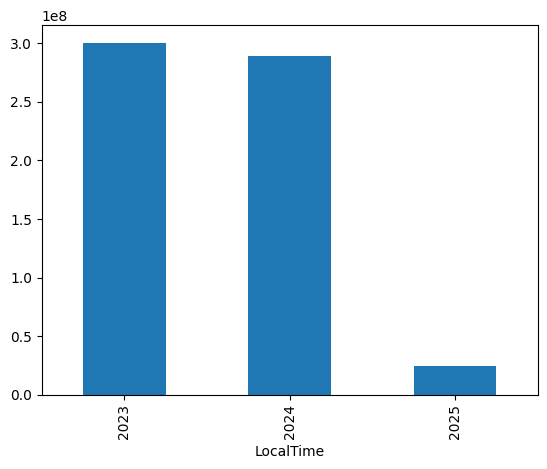

In [8]:
filtered_df.groupby(filtered_df['LocalTime'].dt.year)['power_kWh'].sum().plot(kind='bar')

In [16]:
predictions_solar_era5.describe()

,time,capacity_MW,Estimated Annual Production GWh,latitude,longitude,grid_latitude,grid_longitude,distance,dist_in_km,u10,...,clear_sky_index,net_radiation,hour,hour_sin,hour_cos,day_of_year,doy_sin,doy_cos,Power(MW),power_kWh
count,516780,516780.000000,46980.0,516780.000000,516780.000000,516780.000000,516780.000000,516780.000000,516780.000000,516780.000000,...,5.167800e+05,5.167800e+05,516780.000000,5.167800e+05,5.167800e+05,516780.000000,516780.000000,516780.000000,516780.000000,516780.000000
mean,2024-01-27 12:49:46.781609216,49.008182,330.0,39.076583,-8.355647,39.068182,-8.363636,0.105091,10.109769,0.859305,...,2.713511e+04,-8.507541e+04,12.454662,-5.552785e-02,-4.645640e-01,172.840358,0.028311,0.058927,13.266946,3316.736583
min,2023-01-01 06:00:00,2.480000,330.0,37.076840,-8.893130,37.000000,-9.000000,0.050720,5.637320,-13.111877,...,0.000000e+00,-1.510232e+06,5.000000,-1.000000e+00,-1.000000e+00,1.000000,-0.999991,-0.999963,-0.052719,-13.179816
25%,2023-07-15 16:11:15,3.000000,330.0,38.199339,-8.852609,38.250000,-8.750000,0.092524,8.462719,-0.902878,...,7.337836e+02,-1.006906e+06,9.000000,-8.660254e-01,-8.660254e-01,72.000000,-0.668064,-0.671260,0.260491,65.122642
50%,2024-01-27 13:22:30,12.720000,330.0,39.101800,-8.555346,39.000000,-8.500000,0.120197,11.029213,0.942169,...,2.584164e+03,-3.330952e+05,12.000000,1.224647e-16,-5.000000e-01,170.000000,0.085965,0.107381,1.746272,436.568123
75%,2024-08-10 08:33:45,60.000000,330.0,40.064196,-7.856660,40.000000,-7.750000,0.121036,11.281631,2.545975,...,3.623803e+03,6.794658e+05,16.000000,7.071068e-01,-1.836970e-16,268.000000,0.693281,0.782980,9.950960,2487.739891
max,2025-02-21 20:45:00,202.000000,330.0,40.824145,-7.144530,40.750000,-7.250000,0.131456,13.002996,13.759567,...,7.482368e+08,2.615971e+06,20.000000,1.000000e+00,5.000000e-01,366.000000,0.999991,1.000000,149.093079,37273.269672
std,NaN,71.036039,0.0,1.105795,0.585206,1.082354,0.577649,0.024063,2.203431,2.586140,...,2.528626e+06,1.033097e+06,4.349097,7.631768e-01,4.457124e-01,109.231947,0.693433,0.717551,27.466683,6866.670725


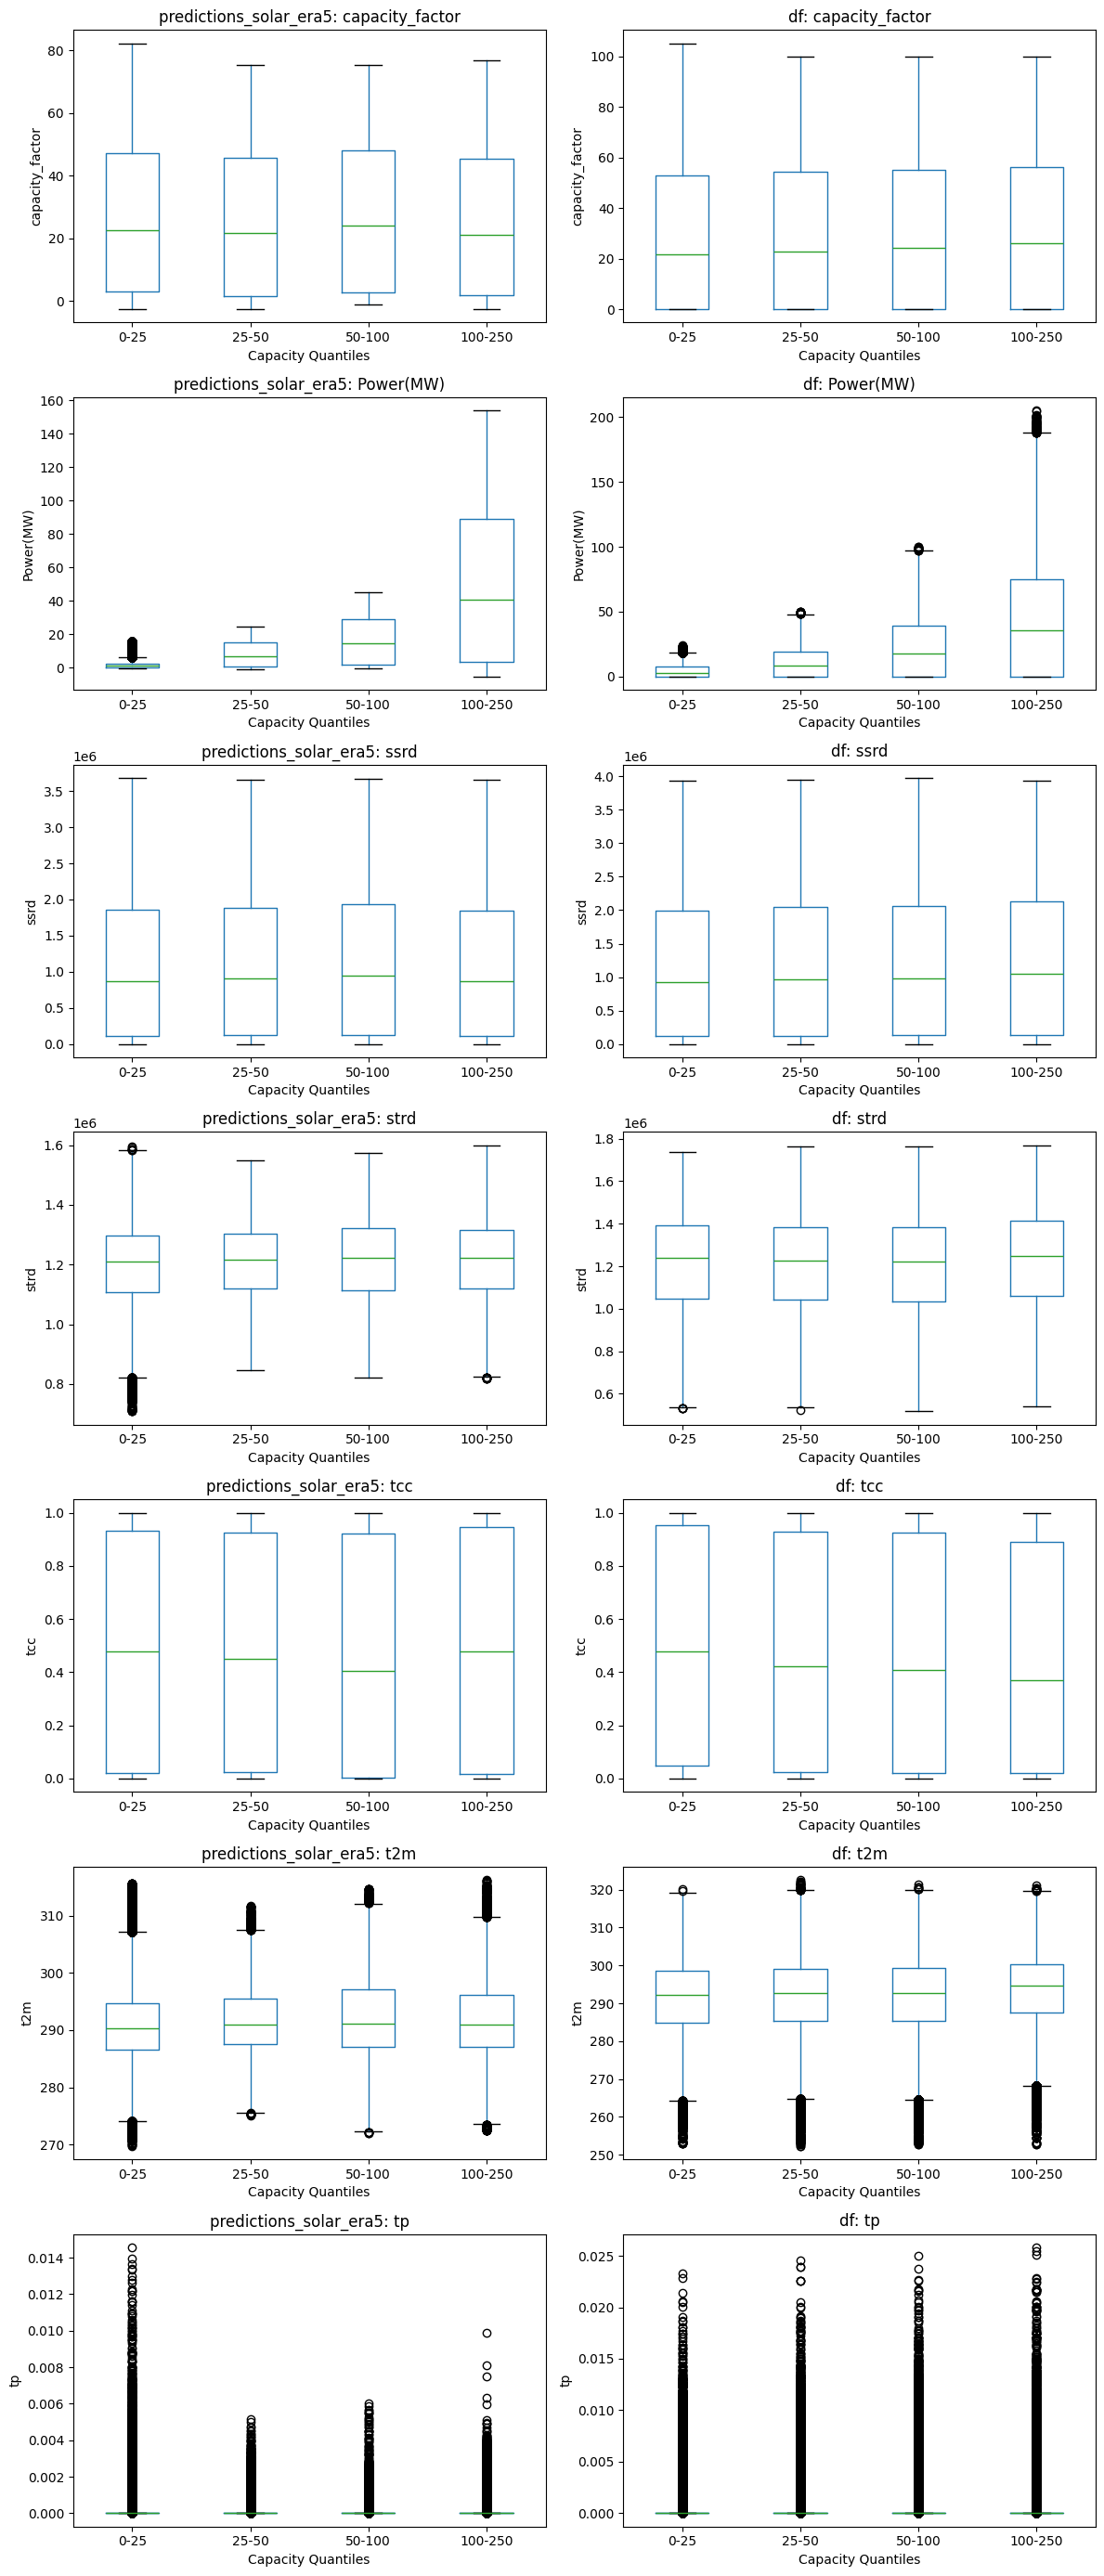

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Compute capacity_factor if not already computed
predictions_solar_era5["capacity_factor"] = (predictions_solar_era5["Power(MW)"] / predictions_solar_era5["capacity_MW"]) * 100
df["capacity_factor"] = (df["Power(MW)"] / df["capacity_MW"]) * 100

bins = [0, 25, 50, 100, 250]
labels = ["0-25", "25-50", "50-100", "100-250"]

# For the predictions_solar_era5 dataset
predictions_solar_era5["capacity_quantile"] = pd.cut(
    predictions_solar_era5["capacity_MW"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# For the df dataset
df["capacity_quantile"] = pd.cut(
    df["capacity_MW"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# List of variables to compare
variables = ["capacity_factor", "Power(MW)", "ssrd", "strd", "tcc", "t2m", "tp"]

# Create a figure with subplots: rows for variables, 2 columns for the two datasets
n_vars = len(variables)
fig, axes = plt.subplots(n_vars, 2, figsize=(12, 4 * n_vars), sharex=False)

for i, var in enumerate(variables):
    # Boxplot for predictions_solar_era5 on the left column
    predictions_solar_era5.boxplot(column=var, by="capacity_quantile", grid=False, ax=axes[i, 0])
    axes[i, 0].set_title(f"predictions_solar_era5: {var}")
    axes[i, 0].set_xlabel("Capacity Quantiles")
    axes[i, 0].set_ylabel(var)
    
    # Boxplot for df on the right column
    df.boxplot(column=var, by="capacity_quantile", grid=False, ax=axes[i, 1])
    axes[i, 1].set_title(f"df: {var}")
    axes[i, 1].set_xlabel("Capacity Quantiles")
    axes[i, 1].set_ylabel(var)

plt.suptitle("")
plt.tight_layout()
plt.show()

In [3]:
df = pd.read_parquet('/Users/darcor/Data/EDP Thesis/Output/temp_batches/batch_1.parquet', engine="fastparquet")
df.head()

,LocalTime,Power(MW),latitude,longitude,year,capacity_MW,UTC,grid_latitude,grid_longitude,distance,...,snd,clear_sky_index,hour,hour_sin,hour_cos,day_of_year,doy_sin,doy_cos,net_radiation,solar_elevation
0,2006-01-01 06:00:00,0.0,40.950001,-94.349998,2006,10.0,2006-01-01 12:00:00+00:00,41.02,-94.269997,0.106301,...,0.0,0.0,6,1.0,6.123234e-17,1,0.017213,0.999852,-958306.6250,-18.633291
1,2006-01-01 06:05:00,0.0,40.950001,-94.349998,2006,10.0,2006-01-01 12:05:00+00:00,41.02,-94.269997,0.106301,...,0.0,0.0,6,1.0,6.123234e-17,1,0.017213,0.999852,-959665.2500,-17.721651
2,2006-01-01 06:10:00,0.0,40.950001,-94.349998,2006,10.0,2006-01-01 12:10:00+00:00,41.02,-94.269997,0.106301,...,0.0,0.0,6,1.0,6.123234e-17,1,0.017213,0.999852,-963648.5625,-16.813240
3,2006-01-01 06:15:00,0.0,40.950001,-94.349998,2006,10.0,2006-01-01 12:15:00+00:00,41.02,-94.269997,0.106301,...,0.0,0.0,6,1.0,6.123234e-17,1,0.017213,0.999852,-969985.0625,-15.908214
4,2006-01-01 06:20:00,0.0,40.950001,-94.349998,2006,10.0,2006-01-01 12:20:00+00:00,41.02,-94.269997,0.106301,...,0.0,0.0,6,1.0,6.123234e-17,1,0.017213,0.999852,-978243.0000,-15.006730


In [ ]:
df.describe()

In [3]:
df.rename(columns={"era5_surface_solar_radiation_downwards": "ssrd",
                   "era5_surface_thermal_radiation_downwards": "strd",
                   "era5_total_cloud_cover": "tcc",
                   "era5_2m_surface_temperature": "t2m",
                   "era5_total_precipitation": "tp",
                   }, inplace=True)

In [4]:
df.head(1000000).to_parquet('/Users/darcor/Data/EDP Thesis/Output/Solar Data/solar_data.parquet', engine='fastparquet')

In [ ]:
# Filter rows first to reduce data size
df = df.query("era5_snow_depth <= 0.01")

df["identifier"] = df["latitude"].astype(str) + "_" + df["longitude"].astype(str)

In [5]:
df.head()

,LocalTime,Power(MW),latitude,longitude,year,capacity_MW,UTC,grid_latitude,grid_longitude,distance,dist_in_km,ssrd,strd,tcc,t2m,tp,era5_snow_depth,identifier
0,2006-01-01 00:00:00,0.0,40.95,-94.35,2006,10.0,2006-01-01 06:00:00+00:00,41.02,-94.27,0.106301,10.279976,0.0,924648.875000,0.942169,273.700684,0.0,0.0,-53.39999999999999
1,2006-01-01 00:05:00,0.0,40.95,-94.35,2006,10.0,2006-01-01 06:05:00+00:00,41.02,-94.27,0.106301,10.279976,0.0,924818.049013,0.914337,273.708605,0.0,0.0,-53.39999999999999
2,2006-01-01 00:10:00,0.0,40.95,-94.35,2006,10.0,2006-01-01 06:10:00+00:00,41.02,-94.27,0.106301,10.279976,0.0,925314.042123,0.886505,273.731830,0.0,0.0,-53.39999999999999
3,2006-01-01 00:15:00,0.0,40.95,-94.35,2006,10.0,2006-01-01 06:15:00+00:00,41.02,-94.27,0.106301,10.279976,0.0,926103.053220,0.858673,273.768776,0.0,0.0,-53.39999999999999
4,2006-01-01 00:20:00,0.0,40.95,-94.35,2006,10.0,2006-01-01 06:20:00+00:00,41.02,-94.27,0.106301,10.279976,0.0,927131.312500,0.830841,273.816925,0.0,0.0,-53.39999999999999


In [2]:
df_filtered = df.iloc[::12]  # Select every 12th row
df_filtered.dropna(inplace=True)

/var/folders/dg/bb0t3rbx0wl1m8sfz_m5h2bw0000gn/T/ipykernel_67553/4050256644.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.dropna(inplace=True)


In [3]:
df_filtered = df_filtered.head(100000)

In [3]:
del df

In [4]:
import numpy as np
# Create month and hour columns using vectorized datetime accessors
df_filtered['month_of_year'] = df_filtered['LocalTime'].dt.month
df_filtered['hour_of_the_day'] = df_filtered['LocalTime'].dt.hour

conditions = [
    df_filtered['month_of_year'].isin([12, 1, 2]),
    df_filtered['month_of_year'].isin([3, 4, 5]),
    df_filtered['month_of_year'].isin([6, 7, 8])
]
choices = ['winter', 'spring', 'summer']
df_filtered['season'] = np.select(conditions, choices, default='fall')

# Create a nighttime dummy variable: 1 if hour is between 10pm and 7am, else 0.
df_filtered['nighttime'] = ((df_filtered['hour_of_the_day'] >= 22) | 
                            (df_filtered['hour_of_the_day'] < 7)).astype(int)

In [5]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

# Define numerical and categorical features
numeric_features = ['capacity_MW', 'era5_surface_solar_radiation_downwards', 'era5_surface_thermal_radiation_downwards',
                    'era5_total_cloud_cover', 'era5_2m_surface_temperature', 'era5_total_precipitation',
                    'era5_snow_depth', 'month_of_year', 'hour_of_the_day', 'nighttime']
categoric_features = ['season']

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Apply one-hot encoding to categorical features
one_hot_encoded = encoder.fit_transform(df_filtered[categoric_features])

# Convert encoded array into a DataFrame
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categoric_features))

# Reset index to align with the original DataFrame
one_hot_encoded_df.index = df_filtered.index

# Concatenate numerical features with one-hot encoded categorical features
X = pd.concat([df_filtered[numeric_features], one_hot_encoded_df], axis=1)

# Define target variable
target = ['Power(MW)']
y = df_filtered[target]

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [7]:
import lightgbm as lgb
import numpy as np
import warnings
from hyperopt import fmin, atpe, hp, Trials, STATUS_OK, space_eval
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold

# Monkey-patch numpy so that np.warnings points to the standard warnings module.
np.warnings = warnings

# Define the hyperparameter search space.
space = {
    'num_leaves': hp.choice('num_leaves', range(10, 100)),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.choice('n_estimators', range(25, 300)),
    'min_child_weight': hp.uniform('min_child_weight', 0.1, 10),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0)
}

def evaluate_model(model, X, y):
    """Return key regression metrics for a fitted model."""
    preds = model.predict(X)
    metrics = {
        "RMSE": np.sqrt(mean_squared_error(y, preds)),
        "MAE": mean_absolute_error(y, preds),
        "R2": r2_score(y, preds)
    }
    return metrics

def objective(params):
    """Objective function using 3-fold cross-validation that prints and averages key metrics."""
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    fold_metrics = []
    
    for train_idx, val_idx in kf.split(X_train):
        # Use .iloc for pandas DataFrames/Series.
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = lgb.LGBMRegressor(**params, random_state=42, verbose=-1)
        
        # Capture and print any warnings during training.
        with warnings.catch_warnings(record=True) as warn_list:
            warnings.simplefilter("always")
            model.fit(X_tr, y_tr)
            for warn in warn_list:
                print(f"Warning in fold: {warn.message}")
                
        metrics = evaluate_model(model, X_val, y_val)
        fold_metrics.append(metrics)
    
    # Average the metrics across folds.
    avg_metrics = {key: np.mean([fold[key] for fold in fold_metrics])
                   for key in fold_metrics[0].keys()}
    print("CV Metrics:", avg_metrics)
    
    # Optimize RMSE (you could also choose a combined metric)
    return {'loss': avg_metrics["RMSE"], 'status': STATUS_OK}

# Run hyperparameter optimization using ATPE.
trials = Trials()
best = fmin(fn=objective, space=space, algo=atpe.suggest, max_evals=50, trials=trials)
# Convert indices from hp.choice to actual values.
best_params = space_eval(space, best)
print("Best hyperparameters:", best_params)

# Train the final model on the full training set.
best_model = lgb.LGBMRegressor(**best_params, random_state=42, verbose=-1)
best_model.fit(X_train, y_train)

# Evaluate on the test set.
final_metrics = evaluate_model(best_model, X_test, y_test)
print("Final Test Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")

CV Metrics:                                           
{'RMSE': 8.6225215055155, 'MAE': 3.8366329333509825, 'R2': 0.8902353664226837}
CV Metrics:                                                                    
{'RMSE': 8.879607689982066, 'MAE': 4.024920913086839, 'R2': 0.8835923318921108}
CV Metrics:                                                                    
{'RMSE': 9.06057945657159, 'MAE': 4.2257074297727995, 'R2': 0.8787991114956716}
CV Metrics:                                                                  
{'RMSE': 8.607882344641764, 'MAE': 3.886374283245687, 'R2': 0.8906076437394707}
CV Metrics:                                                                      
{'RMSE': 9.134055726058705, 'MAE': 4.402877615276396, 'R2': 0.876825454928522}   
CV Metrics:                                                                       
{'RMSE': 8.983212961029507, 'MAE': 4.110140963499099, 'R2': 0.8808600704542989}   
CV Metrics:                                               

KeyboardInterrupt: 

In [3]:
import xarray as xr
ds = xr.open_dataset("/Users/darcor/Data/EDP Thesis/Output/Climate Data/copernicus_rcp_4_5_portugal_future.nc", engine='netcdf4')

In [1]:
import xarray as xr
ds = xr.open_dataset("/Users/darcor/Data/EDP Thesis/Output/Climate Data/clt_EUR-11_CNRM-CERFACS-CNRM-CM5_rcp26_r1i1p1_CNRM-ALADIN63_v2_3hr_202501010130-202512312230.nc", engine='netcdf4')
ds.info()

xarray.Dataset {
dimensions:
	time = 2920 ;
	axis_nbounds = 2 ;
	y = 453 ;
	x = 453 ;
	nvertex = 4 ;

variables:
	datetime64[ns] time(time) ;
		time:axis = T ;
		time:standard_name = time ;
		time:long_name = Time axis ;
		time:time_origin = 1949-12-01 00:00:00 ;
		time:bounds = time_bounds ;
	datetime64[ns] time_bounds(time, axis_nbounds) ;
	float32 clt(time, y, x) ;
		clt:standard_name = cloud_area_fraction ;
		clt:long_name = Total Cloud Fraction ;
		clt:units = % ;
		clt:online_operation = average ;
		clt:interval_operation = 450 s ;
		clt:interval_write = 3 h ;
		clt:cell_methods = time: mean ;
		clt:grid_mapping = Lambert_Conformal ;
	float64 lon(y, x) ;
		lon:standard_name = longitude ;
		lon:long_name = Longitude ;
		lon:units = degrees_east ;
		lon:bounds = bounds_lon ;
	float64 lat(y, x) ;
		lat:standard_name = latitude ;
		lat:long_name = Latitude ;
		lat:units = degrees_north ;
		lat:bounds = bounds_lat ;
	|S1 Lambert_Conformal() ;
		Lambert_Conformal:latitude_of_projection

In [12]:
import xarray as xr

# Open the datasets
ds_future = xr.open_dataset("/Users/darcor/Data/EDP Thesis/Output/Climate Data/copernicus_rcp_2_6_portugal_future.nc")

# Assuming the variable to update is 'clt'
# Combine them so that non-missing values in ds_2025 override the missing ones in ds_future
#ds_future["clt"] = ds_future["clt"].combine_first(clt_2_6_2025["clt"])

# Save the updated dataset
#ds_future.to_netcdf("merged_updated.nc")

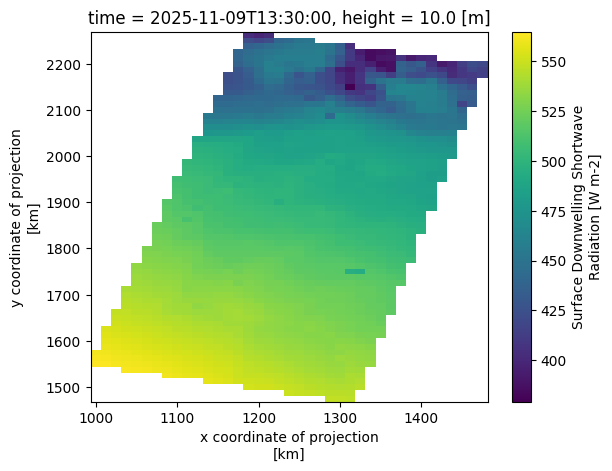

In [7]:
import matplotlib.pyplot as plt

# Plot the first time index; adjust index if needed
ds.rsds.isel(time=5000).plot()
plt.show()